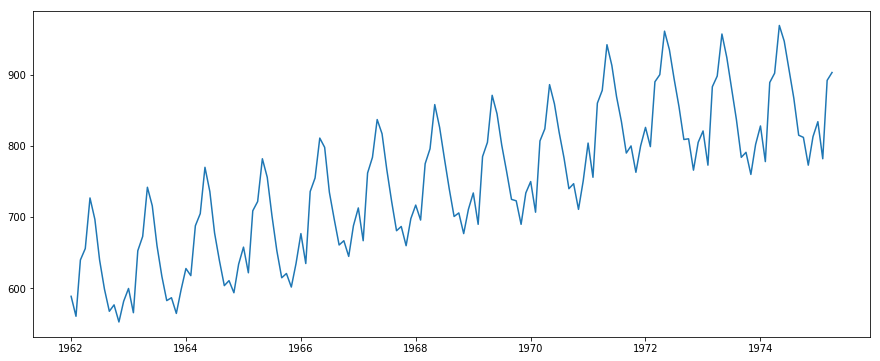

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('monthly-milk-production-pounds-p (1).csv', parse_dates=['Month'], index_col='Month', nrows=160, date_parser = dateparse)
data = data.dropna()

ts = data["Monthly milk production: pounds per cow. Jan 62 ? Dec 75"]
ts = ts.dropna()

plt.plot(ts)


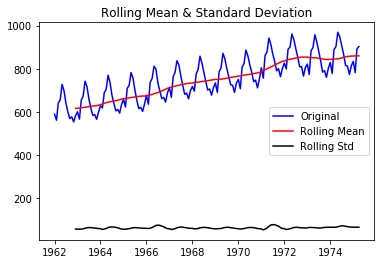

Results of Dickey-Fuller Test:
Test Statistic                  -1.518984
p-value                          0.524100
#Lags Used                      13.000000
Number of Observations Used    146.000000
Critical Value (1%)             -3.475953
Critical Value (5%)             -2.881548
Critical Value (10%)            -2.577439
dtype: float64


In [2]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(timeseries):
    
    rollingmean = timeseries.rolling(window=12).mean()
    rollingstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rollingmean, color='red', label='Rolling Mean')
    std = plt.plot(rollingstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform DF test:
    print ('Results of Dickey-Fuller Test:')
    dataframetest = adfuller(timeseries, autolag='AIC')
    dataframeoutput = pd.Series(dataframetest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dataframetest[4].items():
        dataframeoutput['Critical Value (%s)'%key] = value
    print (dataframeoutput)
    
testStationarity(ts)


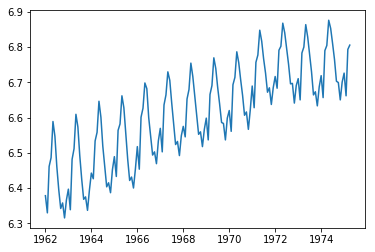

In [3]:
ts_log = np.log(ts)
plt.plot(ts_log)


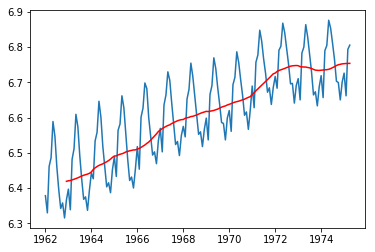

In [4]:
movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color='red')


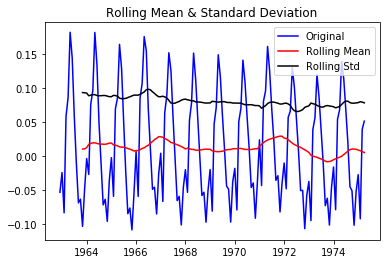

Results of Dickey-Fuller Test:
Test Statistic                  -2.973552
p-value                          0.037439
#Lags Used                      13.000000
Number of Observations Used    135.000000
Critical Value (1%)             -3.479743
Critical Value (5%)             -2.883198
Critical Value (10%)            -2.578320
dtype: float64


In [5]:
ts_log_moving_avg_diff = ts_log - movingAverage
ts_log_moving_avg_diff.head(12)
ts_log_moving_avg_diff.dropna(inplace=True)
testStationarity(ts_log_moving_avg_diff)


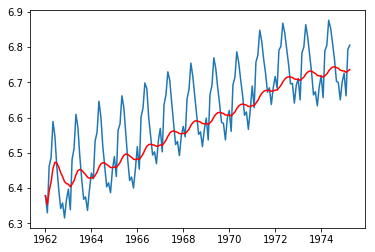

In [6]:
exponentialDecayWeightedAverage = ts_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(ts_log)
plt.plot(exponentialDecayWeightedAverage, color='red')

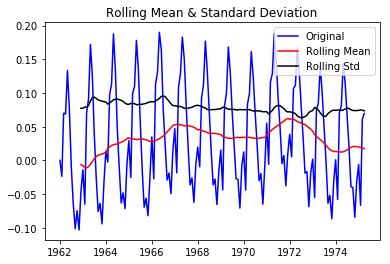

Results of Dickey-Fuller Test:
Test Statistic                  -3.779394
p-value                          0.003125
#Lags Used                      13.000000
Number of Observations Used    146.000000
Critical Value (1%)             -3.475953
Critical Value (5%)             -2.881548
Critical Value (10%)            -2.577439
dtype: float64


In [7]:
ts_log_ewma_diff = ts_log - exponentialDecayWeightedAverage

testStationarity(ts_log_ewma_diff)

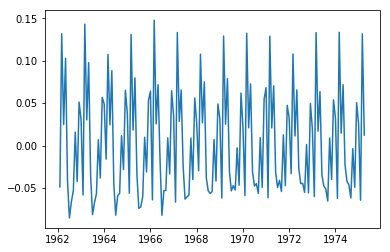

In [8]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

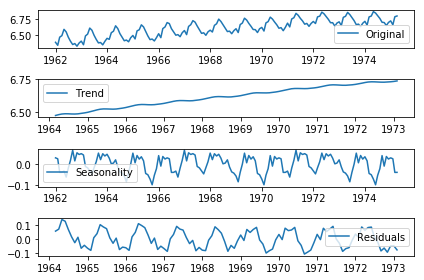

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


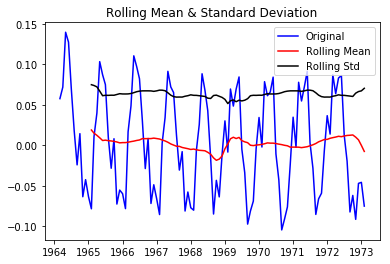

Results of Dickey-Fuller Test:
Test Statistic                 -2.703431
p-value                         0.073446
#Lags Used                      8.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


In [10]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

testStationarity(ts_log_decompose)

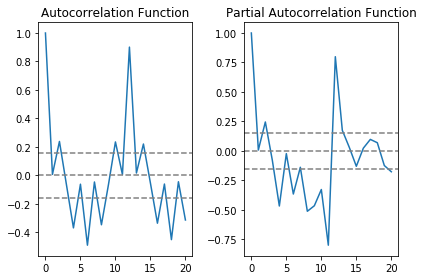

In [11]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf



ts_log_diff= ts_log_diff.dropna()
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.5589')

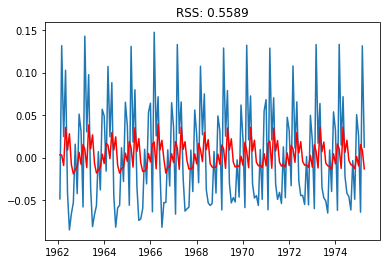

In [42]:
from statsmodels.tsa.arima_model import ARIMA
#Autoregressive model
model = ARIMA(ts_log, order=(2, 1, 0)) 
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.5183')

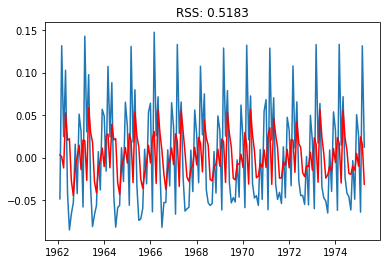

In [43]:
#moving average model
model = ARIMA(ts_log, order=(0, 1, 2)) 
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.5190')

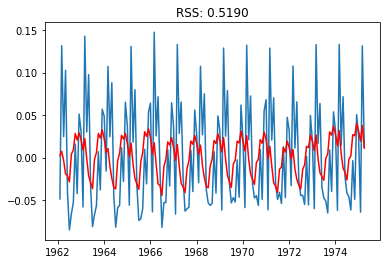

In [44]:

#arima
model = ARIMA(ts_log, order=(2, 1, 2)) 
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

Month
1962-02-01      2.324332
1962-03-01      4.110770
1962-04-01     -0.207223
1962-05-01     21.664083
1962-06-01     28.352927
1962-07-01     47.593836
1962-08-01     40.967620
1962-09-01     27.734252
1962-10-01     18.674519
1962-11-01     12.670767
1962-12-01     16.332136
1963-01-01     12.361506
1963-02-01     21.631032
1963-03-01     27.432914
1963-04-01     21.705590
1963-05-01     45.650456
1963-06-01     53.323047
1963-07-01     72.111857
1963-08-01     66.509162
1963-09-01     53.501844
1963-10-01     43.897205
1963-11-01     37.069465
1963-12-01     39.494521
1964-01-01     36.082055
1964-02-01     46.520940
1964-03-01     55.671807
1964-04-01     55.780679
1964-05-01     75.392149
1964-06-01     82.254011
1964-07-01     99.926492
                 ...    
1972-11-01    281.404567
1972-12-01    282.780249
1973-01-01    273.890880
1973-02-01    285.659549
1973-03-01    290.770688
1973-04-01    281.812375
1973-05-01    311.499967
1973-06-01    317.777149
1973-07-01    333.9

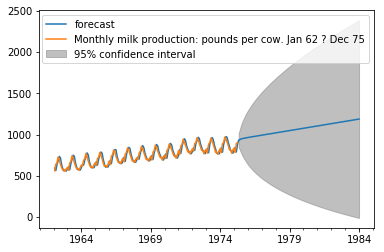

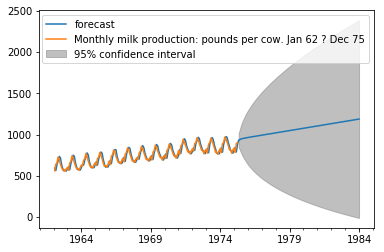

In [45]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

predictions_ARIMA = np.exp(predictions_ARIMA_log)

results_ARIMA.plot_predict(1,264) 